Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model works
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a model available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Literary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for literary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelty of British women publishing novels during the early 19th century. 

Can we help close a literary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning algorithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [3]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

/home/john/.local/lib/python3.8/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/home/john/.local/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/home/john/.local/lib/python3.8/site-packages/gensim/models/doc2vec.py:73: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import namedtuple, defaultdict, Iterable


In [4]:
gensim.__version__

'3.8.1'

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chunks

In [5]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [6]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [7]:
import os

def gather_data(path_to_data): 
    data = []
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))       
    return data

In [8]:
tokens = gather_data(path)

In [9]:
tokens[0][0:10]

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich']

In [10]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

## Follow Along

In [11]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [12]:
len(titles)

813

In [13]:
len(tokens)

813

### Author DataFrame


In [14]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [15]:
df.head()

# There is be 15 different array to explain the 15 different topics

,tokens
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo..."
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p..."
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be..."
Austen_Emma0003,"[native, highbury, born, respectable, family, ..."
Austen_Emma0004,"[mention, handsome, letter, weston, received, ..."


In [16]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [17]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [18]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [19]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our function. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this function later on. 

In [20]:
#char_names_list = [] ...long and efficient way, so use spacy named entity recognition

# This is for getting tokens

def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(text)
                yield tokens

In [21]:
streaming_data = doc_stream(path)

In [22]:
# Generators more efficient when can not hold all of the data in RAM

# Start here to reset generator

type(streaming_data)

generator

In [23]:
# gather_data => returns a list
# doc_stream => returns a generator

In [24]:
next(streaming_data) # Returns one document at a time from the generator

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich',
 'comfortable',
 'home',
 'happy',
 'disposition',
 'unite',
 'best',
 'blessings',
 'existence',
 'lived',
 'nearly',
 'years',
 'world',
 'little',
 'distress',
 'vex',
 'youngest',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period',
 'mother',
 'died',
 'long',
 'ago',
 'indistinct',
 'remembrance',
 'caresses',
 'place',
 'supplied',
 'excellent',
 'woman',
 'governess',
 'fallen',
 'little',
 'short',
 'mother',
 'affection',
 'sixteen',
 'years',
 'miss',
 'taylor',
 'woodhouse',
 'family',
 'governess',
 'friend',
 'fond',
 'daughters',
 'particularly',
 'emma',
 'intimacy',
 'sisters',
 'miss',
 'taylor',
 'ceased',
 'hold',
 'nominal',
 'office',
 'governess',
 'mildness',
 'temper',
 'hardly',
 'allowed',
 'impose',
 'restraint',
 'shadow',
 'authority',
 'long',
 'passed',
 'away',


### Gensim LDA Topic Modeling

In [25]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [26]:
id2word.token2id['england']

3986

In [27]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2753, 1), (3986, 3), (6601, 1), (6818, 1)]

In [28]:
import sys
print(sys.getsizeof(id2word))
print(sys.getsizeof(tokens))

48
7048


In [29]:
len(id2word.keys())

22095

In [30]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [31]:
len(id2word.keys())

8102

In [32]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [33]:
corpus[345][:10]

[(0, 1),
 (2, 1),
 (11, 1),
 (21, 2),
 (32, 1),
 (34, 1),
 (35, 1),
 (37, 1),
 (53, 1),
 (54, 1)]

In [34]:
id2word[21]

'away'

In [35]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15, # depends on the corpus
                   passes=10,
                   workers=12
                  )

# sklearn does all the computations right away, but gensim does not do this, it uses the print_topics() method

In [36]:
lda.print_topics()

[(0,
  '0.016*"harriet" + 0.015*"emma" + 0.009*"weston" + 0.008*"elton" + 0.008*"good" + 0.008*"think" + 0.008*"man" + 0.007*"miss" + 0.007*"knightley" + 0.006*"know"'),
 (1,
  '0.006*"like" + 0.006*"sir" + 0.006*"jane" + 0.006*"thought" + 0.005*"little" + 0.005*"good" + 0.005*"love" + 0.004*"old" + 0.004*"poor" + 0.004*"man"'),
 (2,
  '0.011*"elinor" + 0.009*"marianne" + 0.008*"elizabeth" + 0.007*"sister" + 0.007*"miss" + 0.005*"time" + 0.005*"darcy" + 0.005*"mother" + 0.005*"soon" + 0.005*"lady"'),
 (3,
  '0.005*"hand" + 0.005*"eyes" + 0.005*"john" + 0.004*"like" + 0.004*"saw" + 0.004*"asked" + 0.004*"little" + 0.003*"time" + 0.003*"know" + 0.003*"sir"'),
 (4,
  '0.014*"miss" + 0.011*"jane" + 0.008*"emma" + 0.008*"know" + 0.007*"thing" + 0.007*"think" + 0.006*"good" + 0.006*"little" + 0.006*"shall" + 0.006*"dear"'),
 (5,
  '0.007*"jane" + 0.006*"elizabeth" + 0.006*"darcy" + 0.006*"know" + 0.005*"wickham" + 0.005*"think" + 0.004*"miss" + 0.004*"good" + 0.004*"love" + 0.004*"letter"'),

In [37]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [38]:
topics = [' '.join(t[0:5]) for t in words]

In [39]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")
    
# difficult with similar topics

------ Topic 0 ------
harriet emma weston elton good

------ Topic 1 ------
like sir jane thought little

------ Topic 2 ------
elinor marianne elizabeth sister miss

------ Topic 3 ------
hand eyes john like saw

------ Topic 4 ------
miss jane emma know thing

------ Topic 5 ------
jane elizabeth darcy know wickham

------ Topic 6 ------
hunsden miss helen temple bread

------ Topic 7 ------
little madame like monsieur vous

------ Topic 8 ------
burns thought like scatcherd miss

------ Topic 9 ------
man bennet young elizabeth collins

------ Topic 10 ------
like little thought long good

------ Topic 11 ------
emma miss knightley harriet thing

------ Topic 12 ------
bretton know dr little lucy

------ Topic 13 ------
thousand mason like know sisters

------ Topic 14 ------
lydia mother wickham father uncle



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [40]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [41]:
#pyLDAvis.gensim.prepare(lda, corpus, id2word) # This will break Jupyer Lab buttons

vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)

pyLDAvis.save_html(vis, "../module4-topic-modeling/pyLDAvisLecture.html")

# Put slider close to 0, hover over a topic, and it will show terms that are more unique to that topic

### Overall Model / Documents

In [42]:
lda[corpus[0]]

[(2, 0.23459537), (11, 0.76339704)]

In [43]:
distro = [lda[d] for d in corpus]

In [44]:
distro[0]

[(2, 0.23459746), (11, 0.76339495)]

In [45]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [46]:
len(new_distro)

813

In [47]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


In [48]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [49]:
df.head()

,harriet emma weston elton good,like sir jane thought little,elinor marianne elizabeth sister miss,hand eyes john like saw,miss jane emma know thing,jane elizabeth darcy know wickham,hunsden miss helen temple bread,little madame like monsieur vous,burns thought like scatcherd miss,man bennet young elizabeth collins,like little thought long good,emma miss knightley harriet thing,bretton know dr little lucy,thousand mason like know sisters,lydia mother wickham father uncle,author
Austen_Emma0000,0.000000,0.0,0.2346,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.763393,0.000000,0.0,0.0,Austen
Austen_Emma0001,0.339857,0.0,0.0000,0.0,0.427919,0.000000,0.0,0.0,0.0,0.0,0.0,0.229969,0.000000,0.0,0.0,Austen
Austen_Emma0002,0.669740,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.327996,0.000000,0.0,0.0,Austen
Austen_Emma0003,0.191080,0.0,0.0000,0.0,0.000000,0.806789,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,Austen
Austen_Emma0004,0.485063,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.106290,0.406799,0.0,0.0,Austen


In [50]:
df.groupby('author').mean()

,harriet emma weston elton good,like sir jane thought little,elinor marianne elizabeth sister miss,hand eyes john like saw,miss jane emma know thing,jane elizabeth darcy know wickham,hunsden miss helen temple bread,little madame like monsieur vous,burns thought like scatcherd miss,man bennet young elizabeth collins,like little thought long good,emma miss knightley harriet thing,bretton know dr little lucy,thousand mason like know sisters,lydia mother wickham father uncle
author,,,,,,,,,,,,,,,
Austen,0.103918,0.006973,0.428129,0.000000,0.211959,0.088507,0.000000,0.000291,0.001807,0.017822,0.013380,0.086611,0.004561,0.000028,0.03330
CBronte,0.003945,0.012633,0.008016,0.013694,0.036295,0.003886,0.005369,0.137135,0.015776,0.000056,0.746323,0.001341,0.007101,0.004740,0.00102


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text preprocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [51]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

# higher coherence means when the topics were taken, words samlpled according to proportions, would recreate the document really well
# complex, but good to have intuition, and study more

In [52]:
# Can take a long time to run.
#%%time

coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=1) # don't want this number to be low, because then the model won't learn, too high and wastes computatinal resources

In [53]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [54]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-0.678043
1,0,4,-0.709777
2,0,6,-0.714067
3,0,8,-0.761545
4,0,10,-0.784399


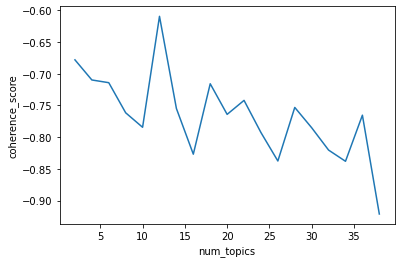

In [55]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# Don't want topics too low, or too high, maybe around 9 in this example, then go back and retrain LDA model on this number
# go back and rename topics with human intuition, not easy to do, but useful
# What are topics useful for? ie: use topics for recommendations

In [58]:
# Print the coherence scores
#for m, cv in zip(x, coherence_values):
#    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [57]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.016701119),
 (1, 0.01670116),
 (2, 0.01670115),
 (3, 0.016701119),
 (4, 0.016701132),
 (5, 0.01670112),
 (6, 0.016701119),
 (7, 0.016701138),
 (8, 0.016701119),
 (9, 0.016701167),
 (10, 0.7661841),
 (11, 0.016701164),
 (12, 0.01670119),
 (13, 0.016701119),
 (14, 0.016701119)]

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)